In [1]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

    

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)

        al=exp(-((x-y)^2)/(omega^2))
        denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
        al/=denom
    
        if(abs(x-y)>t)
            al=0
        end
    
    return al

end

function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
    
    alpha=0.0
    
    if ( x-y > -t && x-y <=0 ) 
        
        alpha=1+ (slope*(x-y))
        
    elseif ( x-y < -t && x-y >0 ) 
        
        alpha=1- (slope*(x-y))
        
    end
    
    return alpha
    
end
    

#parameter combinations

reps=collect(1:20)
loci=[3,5,10,15,20]




5-element Vector{Int64}:
  3
  5
 10
 15
 20

In [68]:
n=20

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

#First use truncated Gaussian competition kernel

omega=0.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

    A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
end

A1= A1 ./ 100
A0= A0 ./ 100

n=20

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

    
#Case 1: Uniformly distributed traits


N1=pdf.(Uniform(0.4,0.6),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(Uniform(means[i]-0.1,means[i]+0.1),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2)+sum(A0[x,:].*N1),1:length(N1))
    
    N1n=N1n ./sum(N1n)

    N11=N1 .* N1n

    betas[i]=sum(N11 .*  geno)

end


In [69]:
#Case 1: Uniformly distributed traits


N1=pdf.(Uniform(0.4,0.6),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(Uniform(means[i]-0.1,means[i]+0.1),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2)+sum(A0[x,:].*N1),1:length(N1))
    
    N1n=N1n ./sum(N1n)

    N11=N1 .* N1n

    betas[i]=sum(N11 .*  geno)

end



81-element Vector{Float64}:
 0.015431995846786416
 0.015539964165818645
 0.015539964165818645
 0.01570414461593056
 0.01570414461593056
 0.015757179742254955
 0.01584553779060021
 0.01584553779060021
 0.015958802047304696
 0.015958802047304696
 0.01599950842626341
 0.01603821407530074
 0.01603821407530074
 ⋮
 0.016197219651051174
 0.01612366819589306
 0.01612366819589306
 0.01612366819589306
 0.016026131637381577
 0.016026131637381577
 0.01595382567198953
 0.015906658081612162
 0.015906658081612162
 0.015767161935319733
 0.015767161935319733
 0.015673597746929654

In [59]:
i=15

means=collect(0.1:0.01:0.9)
N1=pdf.(Uniform(0.4,0.6),geno)
N1=N1 ./ sum(N1)

N2=pdf.(Uniform(means[i]-0.1,means[i]+0.1),geno)
N2= N2 ./ sum(N2)
N1n= map(x-> sum(A1[x,:].*N2)+sum(A0[x,:].*N1),1:length(N1))


41-element Vector{Float64}:
 0.0024327333161255783
 0.0027389164984274383
 0.0030581483742647174
 0.00338959088096096
 0.0037322738238247414
 0.003930705143129782
 0.0041222605882945285
 0.00430494428301732
 0.004476777501081641
 0.004635833122064533
 0.004780270607917447
 0.004908370646380606
 0.005018568577103791
 ⋮
 0.0035811509486549297
 0.0033195175931826516
 0.00306045520492699
 0.0028054289102582156
 0.0025558229147058303
 0.0023129197489395207
 0.0021562700008052943
 0.002000525632577815
 0.0017077140837487282
 0.0014326430898360387
 0.0011755266066884444
 0.0009363913728111125

In [60]:
sum(N1.*geno)

0.4999999999999999

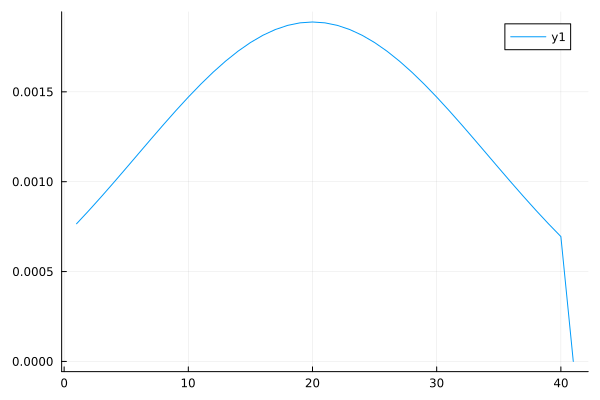

In [66]:
plot(A1[20,:])

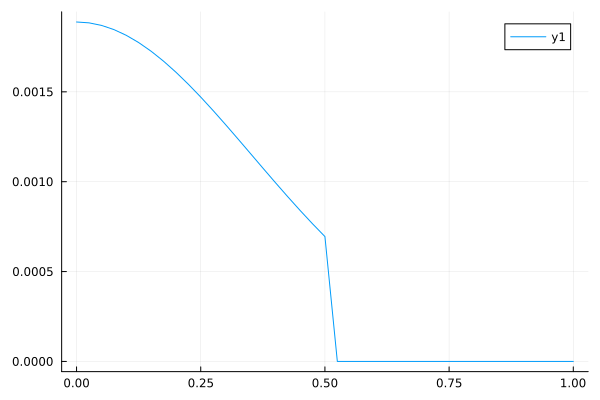

In [41]:
plot(geno,A1[1,:])

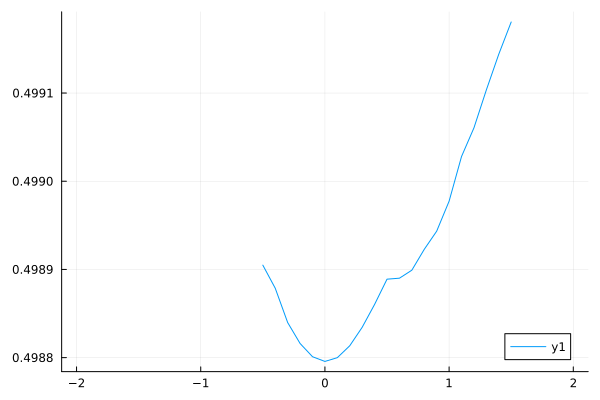

In [44]:
plot(means,betas)

In [4]:
#Case 2: Gaussian (truncated) distributed traits


N1=pdf.(Uniform(0.4,0.6),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(Uniform(means[i]-0.1,means[i]+0.1),geno)

    N2= N2 ./ sum(N2)

    N1n=N1 .+ (N1.*(1 .- map(x-> N1[x]*(sum(A1[x,:].*N2)+sum(A0[x,:].*N1)),1:length(N1))))

    betas[i]=sum(geno.*N1n)

end



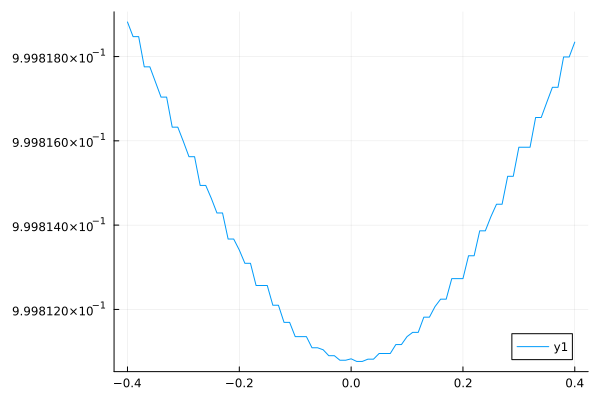

In [9]:
plot(means.-0.5,betas)

In [ ]:
#Plot beta function shapes by varying a)shapes of trait distributions b)competition kernels

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

#First use truncated Gaussian competition kernel

omega=0.5
t=1.0
a1=0.1
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

    A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
end

A1= A1 ./ 100
A0= A0 ./ 100

n=20

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)


    
#Case 1: Uniformly distributed traits

N1=pdf.(Uniform(),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))
    
    N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)
    
    N2= N2 ./ sum(N2)
    
    
    
    
for i1 in 1:size(newp)[1], i2 in 1:size(newp)[2]
        
        comps=sum(A1[i2,:] .* newp[1:end .!=i1,:]') + sum(A0[i2,:] .* newp[i1,:]) 
        Np[i1,i2]=newp[i1,i2]+(newp[i1,i2]*(1-comps))

end
 




In [ ]:
n=10
nsp=22

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

In [ ]:
plot(geno,N[1,:])




In [ ]:


        
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
        
#Start the simulation
for m in 1:1000
    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0

    if all(sum(Np,dims=2) ==0) 
        break
        else
        
        newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    

In [ ]:
nsp=2
n=10


geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)
    
    N=ones(Float64, nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    
    result=DataFrame()
        
        omega=0.5
        t=0.5
        a1=0.5
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:100
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

                dat1=DataFrame(nloci=n,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)

        end 
        

    

In [ ]:
result

In [ ]:

function compsim(par::Tuple{Int64, Int64})
    
    rep=par[1]
    n=par[2]

    geno= collect(range(-1,stop=1,length=2*n+1))
    nt=length(geno)
    
    N=rand(Uniform(0,1.0), nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    omegas=[0.1,0.5]
    ts=[0.2,0.5,2]
    a1s=[0.1,0.5,1]
    
    result=DataFrame()
        
    for i in omegas, j in ts, k in a1s
        
        omega=i
        t=j
        a1=k
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    
    CSV.write(string("compSK_",rep,"_",n,"_",".csv"),result)

end
